# Preparación del Conjunto de Datos:
## 1º Cargaré el archivo csv donde están los datos y haré la preparación y selección de los datos para el modelo con los pasos que ejecuté en el sprint anterior.
* Selecciono los datos finanacieros y demográficos relevantes 

In [1]:
# Lo primero que hago es importar pandas para trabajar con los datos.
import pandas as pd 

# Creo un objeto que llamaré df donde con la función de pandas read.csv le indico la ruta del archivo.
df = pd.read_csv(r"C:\Users\javie\Downloads\bank_dataset.CSV")

# Indico las columnas que contienen los datos que quiero seleccionar.
df = df[['age','job','marital','education','default','balance','housing','loan','deposit']]

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11152 non-null  float64
 1   job        11162 non-null  object 
 2   marital    11157 non-null  object 
 3   education  11155 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  int64  
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   deposit    11162 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 785.0+ KB


## 2º Imputación de valores nulos

In [2]:
# Cuento los valores nulos en cada columna.
df.isnull().sum()

age          10
job           0
marital       5
education     7
default       0
balance       0
housing       0
loan          0
deposit       0
dtype: int64

* Hago la imputación de los valores nulos

In [3]:
# Sustituyo los nulos de la edad por su moda teniendo en cuenta los campos de job, marital y education ajustando los perfiles de coincidencia 
mediana_age = df.groupby(["job", "marital", "education"])["age"].transform(lambda x: x.median() if not x.isnull().all() else x.median())
df["age"] = df["age"].fillna(mediana_age.round())

# Sustituyo los nulos de marital con la moda de los registros teniendo en cuenta la edad y el trabajo para ajustar un poco más la coincidencia
moda_marital = df.groupby(["job", "age"])["marital"].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df["marital"] = df["marital"].fillna(moda_marital)

# Sustituyo los nulos de education con la moda de los registros que tengan la misma edad y trabajo para ajustar la coincidencia
moda_education = df.groupby(["job", "age"])["education"].transform(lambda x: x.mode().iloc[0] if not x.isnull().all() else None)
df["education"] = df["education"].fillna(moda_education)

# Vuelvo a contar los valores nulos para comprobar de que han sido sustituidos
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
deposit      0
dtype: int64

## 3º Tratamiento de outliers.  
* Trato los outliers de age y balance como en el S5 y los guardo en un nuevo df_copy

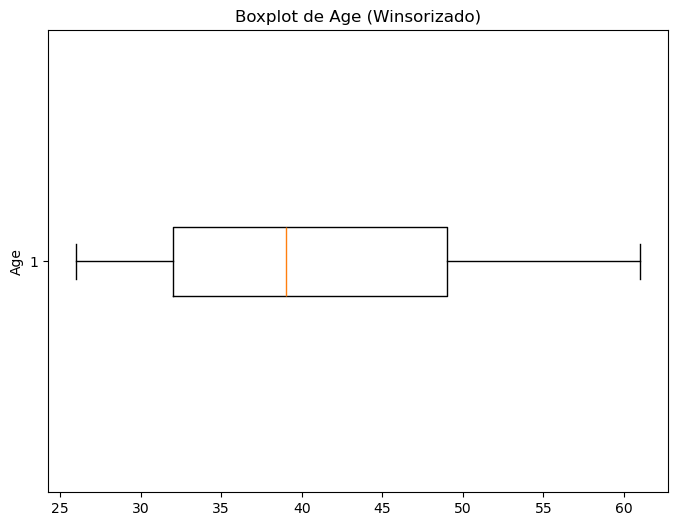

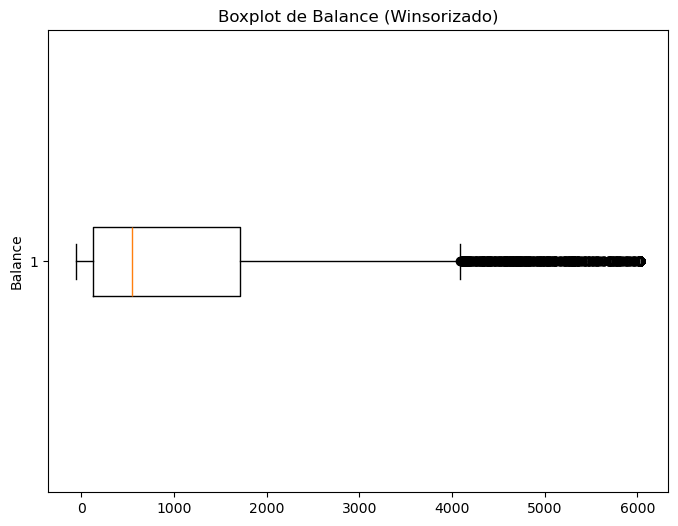

In [4]:
# Importo matplotlib para la gráfica y winsorize para tratar los outliers.
import matplotlib.pyplot as plt 
from scipy.stats.mstats import winsorize

# Creo una copia del DataFrame para evitar modificar el original
df_copy = df.copy()

# Reemplazo los valores extremos en las columnas 'age' y 'balance' por los valores de los percentiles 5 y 95.
df_copy['age'] = winsorize(df_copy['age'], limits=[0.05, 0.05])  # Limita los valores fuera de los percentiles 5-95
df_copy['balance'] = winsorize(df_copy['balance'], limits=[0.05, 0.05])  # Limita los valores fuera de los percentiles 5-95

# Creación del boxplot de la columna 'age' en el DataFrame winsorizado
plt.figure(figsize=(8, 6))
plt.boxplot(df_copy['age'], vert=False)
plt.title('Boxplot de Age (Winsorizado)')
plt.ylabel('Age')
plt.show()

# Creación del boxplot de la columna 'balance' en el DataFrame winsorizado
plt.figure(figsize=(8, 6))
plt.boxplot(df_copy['balance'], vert=False)
plt.title('Boxplot de Balance (Winsorizado)')
plt.ylabel('Balance')
plt.show()


# 4º División del conjunto de datos:
* La división la he realizado con un 80% de los datos para train (8,929 registros) y un 20% para test (2,233 registros). Considero esta proporción adecuada para un dataset de este tamaño, ya que permite entrenar el modelo con una cantidad significativa de datos mientras se reserva un conjunto suficiente para evaluar su rendimiento.
* Para mi modelo el cual será de aprendizaje supervisado estoy seleccionando deposit como etiqueta .

In [5]:
# Importo train_test_split de sklearn para dividir los datos en conjuntos de entrenamiento y prueba.
from sklearn.model_selection import train_test_split

# Creo el objeto 'X' para las características y el objeto 'Y' para la etiqueta o variable objetivo.
X = df_copy.loc[:, ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan']]
Y = df_copy.loc[:, ['deposit']]

# Realizo la separación de los datos en entrenamiento y prueba, utilizando el 20% para pruebas.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

# Imprimo la información sobre los conjuntos de entrenamiento y prueba.
print(f'Los datos de entrenamiento contienen {X_train.shape[0]} filas, {X_train.shape[1]} características y {Y_train.shape[1]} etiquetas.')
print(f'Los datos de prueba contienen {X_test.shape[0]} filas, {X_test.shape[1]} características y {Y_test.shape[1]} etiquetas.')


Los datos de entrenamiento contienen 8929 filas, 8 características y 1 etiquetas.
Los datos de prueba contienen 2233 filas, 8 características y 1 etiquetas.


# 5º Codificación de variables Categóricas:
* Busco las categorias en el df_copy


In [6]:
# Itero sobre las columnas del DataFrame que tienen tipo de dato 'object' (categóricas).
for column in df_copy.select_dtypes(include=['object']).columns:
    
    # Imprimo el nombre de la variable, su número total de categorías y la distribución de los valores.
    print(f"La variable {column.upper()} tiene un total de {df_copy[column].nunique()} categorías \
    \n{df_copy[column].value_counts()}\
    \n \n------------------------\n")


La variable JOB tiene un total de 12 categorías     
job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64    
 
------------------------

La variable MARITAL tiene un total de 3 categorías     
marital
married     6353
single      3518
divorced    1291
Name: count, dtype: int64    
 
------------------------

La variable EDUCATION tiene un total de 4 categorías     
education
secondary    5479
tertiary     3687
primary      1500
unknown       496
Name: count, dtype: int64    
 
------------------------

La variable DEFAULT tiene un total de 2 categorías     
default
no     10994
yes      168
Name: count, dtype: int64    
 
------------------------

La variable HOUSING tiene un total de 2 categorías     
housing
no     5881
yes    5281
Name: count, d

* Ejecuto Label Encoding para las características default, loan y housing ya que son características binarias ( yes/no)

In [7]:
# Defino las variables binarias
binary_variable = ['default', 'loan', 'housing']

# Convierto las características binarias en 0 y 1 usando map, tanto de datos de entrenamiento como de prueba
for variable in binary_variable:
    X_train[variable] = X_train[variable].map({'no': 0, 'yes': 1}).astype(int)
    X_test[variable] = X_test[variable].map({'no': 0, 'yes': 1}).astype(int)

# Convierto la etiqueta 'deposit' en 0 y 1, tanto de datos de entrenamiento como de prueba
Y_train['deposit'] = Y_train['deposit'].map({'no': 0, 'yes': 1}).astype(int)
Y_test['deposit'] = Y_test['deposit'].map({'no': 0, 'yes': 1}).astype(int)


* Procedo a hacer Label Encoding a education ya que es una variable ordinal

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Suponiendo que tienes un DataFrame llamado df_copy
# ...

# Crear un objeto LabelEncoder
le = LabelEncoder()

# Ajustar y transformar la columna 'education'
X_train['education'] = le.fit_transform(X_train['education'])
X_test['education'] = le.fit_transform(X_test['education'])


print(X_train)

        age          job   marital  education  default  balance  housing  loan
2536   60.0      retired   married          3        0      209        0     0
8283   51.0   management   married          0        0     6027        1     0
10439  58.0      retired  divorced          1        0        0        0     0
2809   61.0      retired   married          0        0     6027        0     0
5590   37.0   management    single          3        0      715        1     0
...     ...          ...       ...        ...      ...      ...      ...   ...
7666   47.0   technician   married          2        0      545        1     0
10894  32.0   management    single          2        0     6027        0     0
9523   46.0   management    single          1        0      244        1     0
5303   33.0   technician   married          1        0     2362        1     0
1033   52.0  blue-collar   married          1        0     6027        0     1

[8929 rows x 8 columns]


* Hago agrupación de categorías de 'job' antes del One Hot Encoding

In [9]:
import pandas as pd

mapping = {
    'management': 'white-collar',
    'admin.': 'white-collar',
    'blue-collar': 'blue-collar',
    'technician': 'blue-collar',
    'services': 'service',
    'self-employed': 'self-employed',
    'student': 'student',
    'unemployed': 'unemployed',
    'entrepreneur': 'self-employed',
    'housemaid': 'service',
    'unknown': 'other'
}

# Aplicamos el mapeo a la columna 'job' para crear una nueva columna 'job_group'
X_train['job'] = X_train['job'].map(mapping)
X_test['job'] = X_test['job'].map(mapping)

print(df)

        age          job  marital  education default  balance housing loan  \
0      59.0       admin.  married  secondary      no     2343     yes   no   
1      56.0       admin.  married  secondary      no       45      no   no   
2      41.0   technician  married  secondary      no     1270     yes   no   
3      55.0     services  married  secondary      no     2476     yes   no   
4      54.0       admin.  married   tertiary      no      184      no   no   
...     ...          ...      ...        ...     ...      ...     ...  ...   
11157  33.0  blue-collar   single    primary      no        1     yes   no   
11158  39.0     services  married  secondary      no      733      no   no   
11159  32.0   technician   single  secondary      no       29      no   no   
11160  43.0   technician  married  secondary      no        0      no  yes   
11161  34.0   technician  married  secondary      no        0      no   no   

      deposit  
0         yes  
1         yes  
2         yes  

* Ejecuto One Hot Encoding

In [10]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Copia los datos de entrenamiento y prueba
encoded_X_train = X_train.copy()
encoded_X_test = X_test.copy()

# Defino las variables categóricas para One-Hot Encoding
encoding_variable = ['job', 'marital']

# Inicializo el encoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Realizo el One-Hot Encoding de los datos de entrenamiento y prueba
for variable in encoding_variable:
    # Primero ajustamos el encoder con los datos de entrenamiento
    encoded_train_results = encoder.fit_transform(X_train[encoding_variable])
    encoded_train_columns = pd.DataFrame(encoded_train_results, 
                                     columns=encoder.get_feature_names_out(encoding_variable), 
                                     index=X_train.index)

    # Luego transformamos los datos de prueba
    encoded_test_results = encoder.transform(X_test[encoding_variable])
    encoded_test_columns = pd.DataFrame(encoded_test_results, 
                                    columns=encoder.get_feature_names_out(encoding_variable), 
                                    index=X_test.index)

# Unir ambas
encoded_X_train = pd.concat([encoded_X_train, encoded_train_columns], axis="columns")
encoded_X_test = pd.concat([encoded_X_test, encoded_test_columns], axis="columns")


# Elimino las columnas originales categóricas de X_train y X_test
encoded_X_train = encoded_X_train.drop(columns=encoding_variable)
encoded_X_test = encoded_X_test.drop(columns=encoding_variable)

# Imprimo los primeros registros de los datos procesados
print("\nEjemplo de datos de entrenamiento después de One-Hot Encoding:")
print(encoded_X_train.head())

print("\nEjemplo de datos de prueba después de One-Hot Encoding:")
print(encoded_X_test.head())



Ejemplo de datos de entrenamiento después de One-Hot Encoding:
        age  education  default  balance  housing  loan  job_other  \
2536   60.0          3        0      209        0     0        0.0   
8283   51.0          0        0     6027        1     0        0.0   
10439  58.0          1        0        0        0     0        0.0   
2809   61.0          0        0     6027        0     0        0.0   
5590   37.0          3        0      715        1     0        0.0   

       job_self-employed  job_service  job_student  job_unemployed  \
2536                 0.0          0.0          0.0             0.0   
8283                 0.0          0.0          0.0             0.0   
10439                0.0          0.0          0.0             0.0   
2809                 0.0          0.0          0.0             0.0   
5590                 0.0          0.0          0.0             0.0   

       job_white-collar  job_nan  marital_married  marital_single  
2536                0.0   

In [11]:
print(f'Los datos de entrenamiento contienen {encoded_X_train.shape[0]} filas, {encoded_X_train.shape[1]} características y {Y_train.shape[1]} etiqueta.')
print(f'Los datos de prueba contienen {encoded_X_test.shape[0]} filas, {encoded_X_test.shape[1]} características y {Y_test.shape[1]} etiqueta.')


Los datos de entrenamiento contienen 8929 filas, 15 características y 1 etiqueta.
Los datos de prueba contienen 2233 filas, 15 características y 1 etiqueta.


In [12]:
encoded_X_train.head()


,age,education,default,balance,housing,loan,job_other,job_self-employed,job_service,job_student,job_unemployed,job_white-collar,job_nan,marital_married,marital_single
2536,60.0,3,0,209,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
8283,51.0,0,0,6027,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
10439,58.0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2809,61.0,0,0,6027,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5590,37.0,3,0,715,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# Estandarización de las Variables Numéricas:
He decidido utilizar StandardScaler para la estandarización de las variables numéricas. Este método transforma los datos para que tengan una media de 0 y una desviación estándar de 1, lo que es especialmente útil cuando las características tienen diferentes escalas y magnitudes. La estandarización es una práctica común en el preprocesamiento de datos, ya que puede mejorar el rendimiento de muchos algoritmos de machine learning.


In [13]:
# Importo StandardScaler de sklearn.preprocessing para estandarizar las variables.
from sklearn.preprocessing import StandardScaler

# Identifico las columnas numéricas en los conjuntos codificados de entrenamiento y prueba.
numeric_columns = encoded_X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Creo el objeto escalador
scaler = StandardScaler()

# Aplico la estandarización en el conjunto de entrenamiento y luego en el de prueba
encoded_X_train[numeric_columns] = scaler.fit_transform(encoded_X_train[numeric_columns])
encoded_X_test[numeric_columns] = scaler.transform(encoded_X_test[numeric_columns])

# Visualizo los datos estandarizados en el conjunto de entrenamiento
encoded_X_train[numeric_columns].head()


,age,balance,job_other,job_self-employed,job_service,job_student,job_unemployed,job_white-collar,job_nan,marital_married,marital_single
2536,1.823905,-0.634594,-0.080154,-0.269356,-0.347083,-0.181908,-0.183218,-0.731606,3.657653,0.866478,-0.675375
8283,0.968317,2.854287,-0.080154,-0.269356,-0.347083,-0.181908,-0.183218,1.366856,-0.273399,0.866478,-0.675375
10439,1.633774,-0.759925,-0.080154,-0.269356,-0.347083,-0.181908,-0.183218,-0.731606,3.657653,-1.154097,-0.675375
2809,1.918970,2.854287,-0.080154,-0.269356,-0.347083,-0.181908,-0.183218,-0.731606,3.657653,0.866478,-0.675375
5590,-0.362598,-0.331161,-0.080154,-0.269356,-0.347083,-0.181908,-0.183218,1.366856,-0.273399,-1.154097,1.480658


Explicación del Resultado: En Age tomando como referencia los registros: 2536, 8283, 10439 teníamos :
Edad (original): 60, 51, 58 
Edad (estandarizado): 1.82, 0.96, 1.63 
Los valores numéricos se centran y normalizan, asegurando que cada variable tenga una influencia similar en el modelo, por lo que se puede ver que el registro 8283 es el que se acerca más a la media porque está más próximo a 0 mientras que el registro 2536 con 1.82 es el que más se aleja.
TENIENDO EN CUENTA QUE SOLO ESTAMOS TOMANDO ESTOS 3 REGISTROS PARA ESTA EXPLICACIÓN DE LOS RESULTADOS.

In [14]:
# Calcular la varianza acumulada
cumulative_variance = encoded_X_train.cumsum()
print("Varianza explicada acumulada:", cumulative_variance)


Varianza explicada acumulada:                 age  education  default       balance  housing  loan  \
2536   1.823905e+00          3        0 -6.345943e-01        0     0   
8283   2.792222e+00          3        0  2.219693e+00        1     0   
10439  4.425996e+00          4        0  1.459767e+00        1     0   
2809   6.344967e+00          4        0  4.314054e+00        1     0   
5590   5.982368e+00          7        0  3.982893e+00        2     0   
...             ...        ...      ...           ...      ...   ...   
7666   2.441314e-02      11466      135 -5.751464e+00     4232  1170   
10894 -8.135121e-01      11468      135 -2.897177e+00     4232  1170   
9523  -3.205222e-01      11469      135 -3.510783e+00     4233  1170   
5303  -1.063382e+00      11470      135 -2.854287e+00     4234  1170   
1033  -1.250777e-12      11471      135 -5.142553e-13     4234  1171   

          job_other  job_self-employed   job_service   job_student  \
2536  -8.015427e-02      -2.693558e

# Paso a entrenar el modelo

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Supongamos que X_train, X_test, y_train, y_test ya están definidos

# Crear un modelo de regresión logística
model = LogisticRegression()

# Entrenar el modeo
model.fit(encoded_X_train, Y_train)

# Hacer predicciones
Y_pred = model.predict(encoded_X_test)

# Evaluar el modelo (usando accuracy)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6166592028660994


C:\Users\javie\anaconda3\envs\entorno_ML\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
